In [16]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns

In [17]:
dateparse = lambda dates: pd.to_datetime(dates)
plt.rcParams['figure.figsize'] = [12, 6]

In [18]:
url = '../lstm/data/AAPL.csv'
dataframe = pd.read_csv(url, parse_dates=['date'], index_col='date', date_parser=dateparse)

In [19]:
df = dataframe[['closeadj','return','cumul','7days','14days']]
dates = df.index.tolist()

Start date is:  2011-01-03 00:00:00
End date is:  2021-09-08 00:00:00


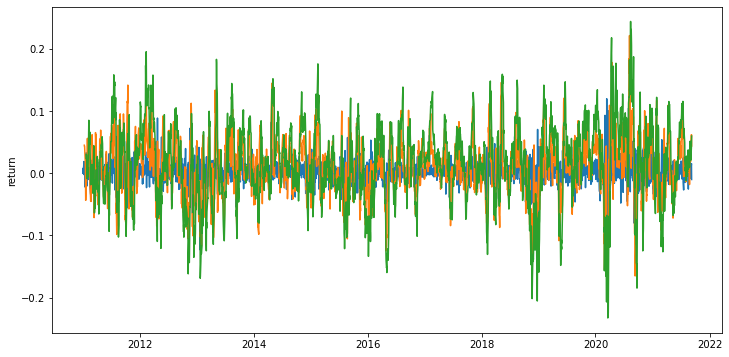

In [20]:
# sns.lineplot(x=dates, y=df['cumul'])
sns.lineplot(x=dates, y=df['return'],legend='brief')
sns.lineplot(x=dates, y=df['7days'],legend='brief')
sns.lineplot(x=dates, y=df['14days'],legend='brief')

print("Start date is: ", min(dates))
print("End date is: ", max(dates))

In [21]:
#tEST data from end 2019....
train, test = df.loc[df.index <= '2019-12-31'], df.loc[df.index > '2019-12-31']
train = train[train.index >= '2011-01-24']

In [22]:
feature_col = 'return'


scaler = StandardScaler()
scaler = scaler.fit(train[[feature_col]])

train[feature_col] = scaler.transform(train[[feature_col]])
test[feature_col] = scaler.transform(test[[feature_col]])

/home/karim/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:

seq_size = 14  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.


def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[[feature_col]], train[feature_col], seq_size)
testX, testY = to_sequences(test[[feature_col]], test[feature_col], seq_size)

In [24]:
# define Autoencoder model
#Input shape would be seq_size, 1 - 1 beacuse we have 1 feature. 
# seq_size = trainX.shape[1]

# s
#Try another model
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 14, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 14, 128)           131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 14, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

Epoch 1/120
63/63 [==============================] - 4s 19ms/step - loss: 0.7192 - val_loss: 0.6709
Epoch 2/120
63/63 [==============================] - 1s 10ms/step - loss: 0.7174 - val_loss: 0.6704
Epoch 3/120
63/63 [==============================] - 1s 10ms/step - loss: 0.7173 - val_loss: 0.6695
Epoch 4/120
63/63 [==============================] - 1s 9ms/step - loss: 0.7173 - val_loss: 0.6733
Epoch 5/120
63/63 [==============================] - 1s 9ms/step - loss: 0.7167 - val_loss: 0.6698
Epoch 6/120
63/63 [==============================] - 1s 9ms/step - loss: 0.7169 - val_loss: 0.6708
Epoch 7/120
63/63 [==============================] - 1s 11ms/step - loss: 0.7163 - val_loss: 0.6711
Epoch 8/120
63/63 [==============================] - 1s 9ms/step - loss: 0.7164 - val_loss: 0.6678
Epoch 9/120
63/63 [==============================] - 1s 10ms/step - loss: 0.7166 - val_loss: 0.6687
Epoch 10/120
63/63 [==============================] - 1s 9ms/step - loss: 0.7160 - val_loss: 0.6701
Epoc

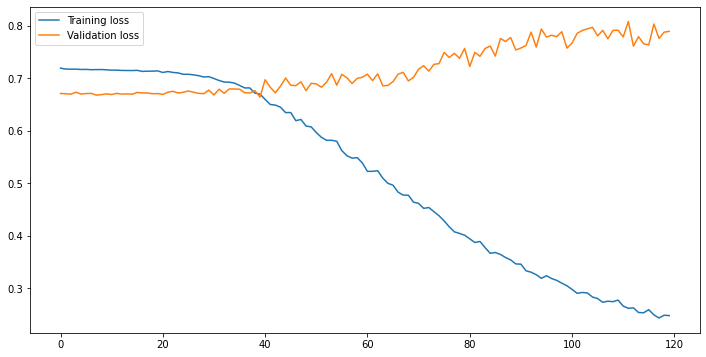

In [25]:
# fit model
history = model.fit(trainX, trainY, epochs=120, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

(array([ 3., 36., 47., 60., 60., 50., 42., 29., 20., 12., 13.,  6.,  3.,
         4.,  6.,  2.,  0.,  3.,  0.,  1.,  2.,  4.,  3.,  1.,  0.,  1.,
         2.,  0.,  0.,  1.]),
 array([0.3312488 , 0.47861262, 0.62597644, 0.77334026, 0.92070408,
        1.0680679 , 1.21543171, 1.36279553, 1.51015935, 1.65752317,
        1.80488699, 1.9522508 , 2.09961462, 2.24697844, 2.39434226,
        2.54170608, 2.6890699 , 2.83643371, 2.98379753, 3.13116135,
        3.27852517, 3.42588899, 3.57325281, 3.72061662, 3.86798044,
        4.01534426, 4.16270808, 4.3100719 , 4.45743571, 4.60479953,
        4.75216335]),
 <BarContainer object of 30 artists>)

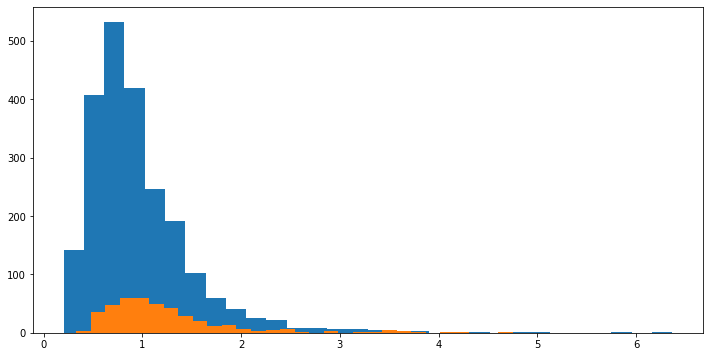

In [26]:

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)
max_trainMAE = 0.3  #or Define 90% value of max as threshold.

testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)


In [27]:

#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df[feature_col] = test[seq_size:][feature_col]


<AxesSubplot:xlabel='date', ylabel='testMAE'>

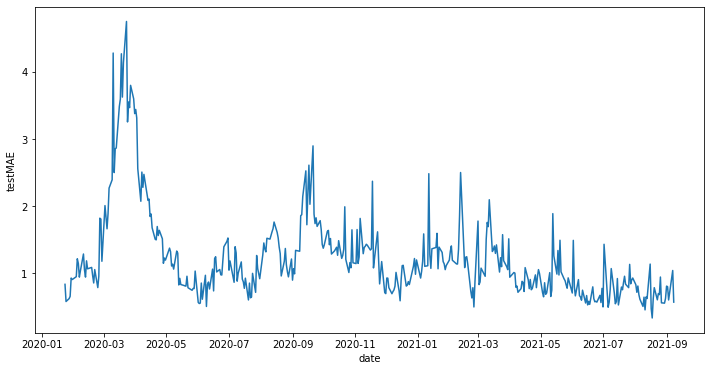

In [35]:

#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df.index, y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df.index, y=anomaly_df['max_trainMAE'])

anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]


<AxesSubplot:xlabel='date'>

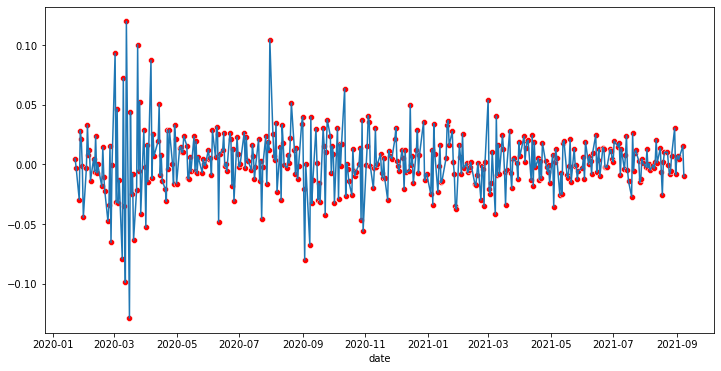

In [29]:

#Plot anomalies
sns.lineplot(x=anomaly_df.index, y=scaler.inverse_transform(anomaly_df[feature_col]))
sns.scatterplot(x=anomalies.index, y=scaler.inverse_transform(anomalies[feature_col]), color='r')